In [18]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from numba import jit

### Data generation

In [19]:
x_dim = 5 # dimension of observations
freq = 0.1 # frequency of class 2 samples
mu_1 = 5*np.random.randn(x_dim,1) # mean of class 1
mu_2 = 5*np.random.randn(x_dim,1) # mean of class 2
sig = np.random.randn(x_dim,x_dim)/np.sqrt(x_dim)
Sigma = sig@sig.T
samples = 1000 # number of data points

In [20]:
class_1 = mu_1 + sig@np.random.randn(x_dim,int(samples*(1-freq)))
class_2 = mu_2 + sig@np.random.randn(x_dim,int(samples*freq))

In [21]:
X = np.concatenate((class_1,class_2),axis=1)
Y = np.zeros((2,samples)); Y[0,:int(samples*(1-freq))] = 1; Y[1,-int(samples*freq):] = 1
idx = np.random.permutation(samples)
X = X[:,idx]
Y = Y[:,idx]

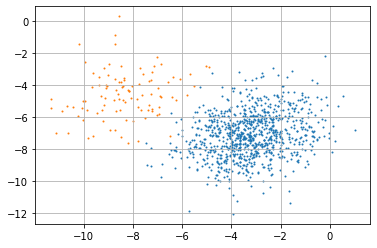

In [22]:
plt.scatter(class_1[0],class_1[1],s=1)
plt.scatter(class_2[0],class_2[1],s=1)
plt.grid()
plt.show()

### Optimal solution

In [23]:
w_opt = np.linalg.inv(Sigma)@(mu_1-mu_2)
w_opt = w_opt/np.sqrt(w_opt.T@Sigma@w_opt)

In [24]:
obj_opt = (w_opt.T@(mu_1-mu_2))**2

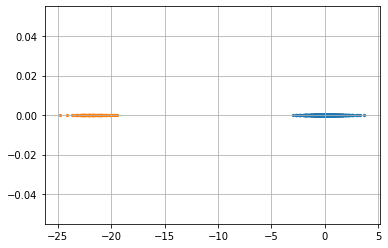

In [25]:
plt.scatter(w_opt.T@class_1,np.zeros((w_opt.T@class_1).shape),s=5)
plt.scatter(w_opt.T@class_2,np.zeros((w_opt.T@class_2).shape),s=5)
plt.grid()
plt.show()

### Offline algorithm

In [13]:
eta = 0.001; gam = 100*eta; iters = 10000

In [14]:
obj = np.zeros(iters)
err = np.zeros(iters)

@jit(nopython=True)
def fit(w, l, mu_1, mu_2, Sigma):
    w = w + eta*(mu_1 - mu_2 - l*Sigma@w)
    l = l + gam*((w.T@Sigma@w).item() - 1)
    
    return w, l
        
def run_offline(mu_1, mu_2, Sigma, eta, gamma, iters):
    
    w = np.random.randn(x_dim,1)/np.sqrt(x_dim)
    l = 1
    
    for i_iter in tqdm(range(iters)):
        w, l = fit(w, l, mu_1, mu_2, Sigma)
        obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
        err[i_iter] = (obj_opt - obj[i_iter])/obj_opt

run_offline(mu_1, mu_2, Sigma, eta, gam, iters)

100%|██████████| 10000/10000 [00:02<00:00, 4394.99it/s]


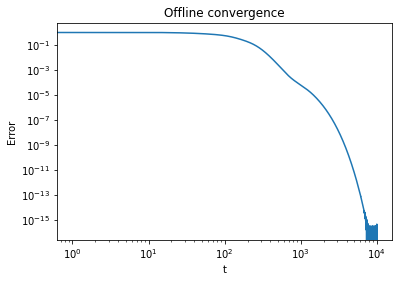

In [15]:
plt.loglog(range(iters), err)
plt.ylabel("Error")
plt.xlabel("t")
plt.title("Offline convergence")
plt.show()

### Online algorithm

In [16]:
@jit(nopython=True)
def eta(t):
    return 1e-4/(1+1e-4*t)

gam = 100; epochs = 20; iters = epochs*samples

In [17]:
@jit(nopython=True)
def fit_online(w, l, mu_1, mu_2, a, b, x, y, t):
    z = w.T@x

    a = max(a + (y[0]-a)/t,1e-5)
    b = max(b + (y[1]-b)/t,1e-5)

    mu_1 += ((y[0]/a)*x - mu_1)/t
    mu_2 += ((y[1]/b)*x - mu_2)/t

    mu = mu_1*y[0] + mu_2*y[1]
    nu = w.T@mu

    step = eta(t)

    w += step*(y[0]/a - y[1]/b)*x - step*l*(z-nu)*(x-mu)
    l += gam*step*((z-nu)**2 - 1)
    
    return w, l, mu_1, mu_2, a, b

def run_online(X, Y):
    
    w = np.random.randn(x_dim)/np.sqrt(x_dim)
    l = 1

    mu_1 = np.zeros(x_dim)
    mu_2 = np.zeros(x_dim)

    a = 0.5
    b = 0.5

    for i_epoch in tqdm(range(epochs)):

        idx = np.random.permutation(samples)

        for i_sample in range(samples):

            i_iter = i_epoch*samples + i_sample

            t = i_iter + 1

            x = X[:,idx[i_sample]]
            y = Y[:,idx[i_sample]]
            
            w, l, mu_1, mu_2, a, b = fit_online(w, l, mu_1, mu_2, a, b, x, y, t)

            obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
            err[i_iter] = abs(obj_opt - obj[i_iter])/obj_opt
            
    return w

obj = np.zeros(iters)
err = np.zeros(iters)

w = run_online(X, Y)

100%|██████████| 20/20 [00:43<00:00,  2.02s/it]


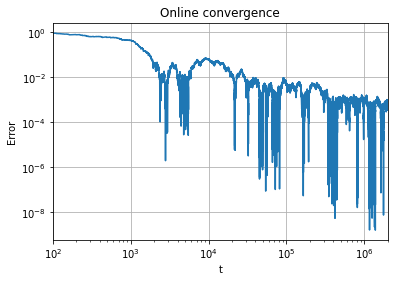

In [18]:
plt.loglog(range(iters), err)
plt.ylabel("Error")
plt.xlabel("t")
plt.xlim(1e2,iters)
plt.grid()
plt.title("Online convergence")
plt.show()

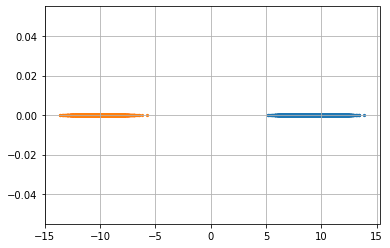

In [19]:
plt.scatter(w.T@class_1,np.zeros((w.T@class_1).shape),s=5)
plt.scatter(w.T@class_2,np.zeros((w.T@class_2).shape),s=5)
plt.grid()
plt.show()

### Online algorithm for sparse class 2 samples

In [20]:
@jit(nopython=True)
def eta(t):
    return 1e-4/(1+1e-4*t)

gam = 100; epochs = 20; iters = epochs*samples

In [21]:
@jit(nopython=True)
def fit_sparse(w, l, mu, b, x, y, t):
    z = w.T@x

    b = max(b + (y[1]-b)/t,1e-5)

    mu += (x - mu)/t
    nu = w.T@mu

    step = eta(t)

    w += step*(x - l*(z-nu)*(x-mu)) - step*y[1]*x/b
    l += gam*step*((z-nu)**2 - 1)
    
    return w, l, mu, b, x, y

def run_sparse(X, Y):
    
    w = np.random.randn(x_dim)/np.sqrt(x_dim)
    l = 1
    
    mu = np.zeros(x_dim)

    b = 0.5

    for i_epoch in tqdm(range(epochs)):

        idx = np.random.permutation(samples)

        for i_sample in range(samples):

            i_iter = i_epoch*samples + i_sample

            t = i_iter + 1

            x = X[:,idx[i_sample]]
            y = Y[:,idx[i_sample]]

            w, l, mu, b, x, y = fit_sparse(w, l, mu, b, x, y, t)
            
            obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
            err_approx[i_iter] = abs(obj_opt - obj[i_iter])/obj_opt
        
        #print(f'Error: {err_approx[i_iter]}')
    return w

obj = np.zeros(iters)
err_approx = np.zeros(iters)

w = run_sparse(X,Y)

100%|██████████| 20/20 [00:43<00:00,  2.14s/it]


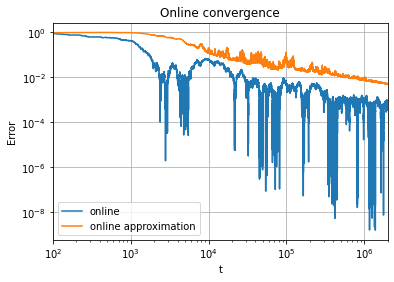

In [22]:
plt.loglog(range(iters), err, label='online')
plt.loglog(range(iters), err_approx, label='online approximation')
plt.ylabel("Error")
plt.xlabel("t")
plt.xlim(1e2,iters)
plt.grid()
plt.legend()
plt.title("Online convergence")
plt.show()

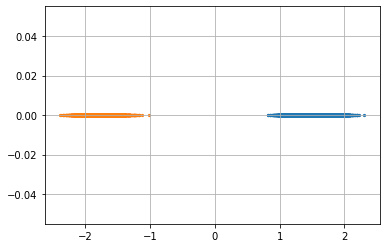

In [23]:
plt.scatter(w.T@class_1,np.zeros((w.T@class_1).shape),s=5)
plt.scatter(w.T@class_2,np.zeros((w.T@class_2).shape),s=5)
plt.grid()
plt.show()

## Paper Online

In [86]:
@jit(nopython=True)
def eta(t):
    return 1e-4/(1+1e-4*t)
gam = 1; epochs = 20; iters = epochs*samples

In [87]:
import optuna





In [88]:
@jit(nopython=True)
def fit_bio(w, l, mu, x, y, zeta, l_, t, eta):
    z = w.T@x - zeta
    
    step = eta(t)
    
    if y[1] == 0:
        mu += (x - mu)/t
        zeta += z/t
        w += step*(mu - l*z*(x-mu))
        l += gam*step*(z**2 - 1)
        l_ += 1
        
    else:
        w -= step*l_*x
        l_ = 1
        
        
    return w, l, mu, x, y, zeta, l_

def run_bio(X, Y, eta):
    
    w = np.random.randn(x_dim)/np.sqrt(x_dim)
    l = 1
    zeta = 0
    l_ = 1
    
    mu = np.zeros(x_dim)

    for i_epoch in tqdm(range(epochs)):

        idx = np.random.permutation(samples)

        for i_sample in range(samples):

            i_iter = i_epoch*samples + i_sample

            t = i_iter + 1

            x = X[:,idx[i_sample]]
            y = Y[:,idx[i_sample]]

            w, l, mu, x, y, zeta, l_ = fit_bio(w, l, mu, x, y, zeta, l_, t, eta)
            
            obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
            err[i_iter] = abs(obj_opt - obj[i_iter])/obj_opt
        
        #print(f'Error: {err_approx[i_iter]}')
    return w

obj = np.zeros(iters)
err = np.zeros(iters)


def objective(trial):
   

    
    e = trial.suggest_discrete_uniform('eta', 4, 10, q=1)
    eta = 10**(-e)
    w = run_bio(X,Y, eta)
    obj_ = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
    return abs(obj_opt - obj_)/obj_opt

optimize = False
if optimize:
    study = optuna.create_study()
    study.optimize(objective, n_trials=100)

    print(study.best_params)
else:
    w = run_bio(X,Y, eta)



100%|██████████| 20/20 [00:01<00:00, 13.40it/s]


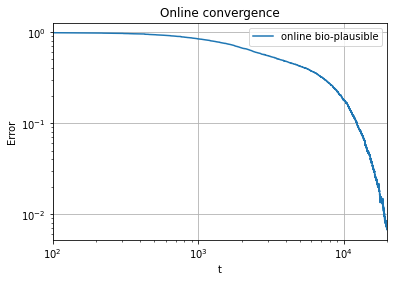

In [89]:
plt.loglog(range(iters), err, label='online bio-plausible')
plt.ylabel("Error")
plt.xlabel("t")
plt.xlim(1e2,iters)
plt.grid()
plt.legend()
plt.title("Online convergence")
plt.show()

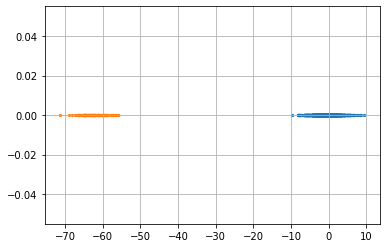

In [90]:
plt.scatter(w.T@class_1,np.zeros((w.T@class_1).shape),s=5)
plt.scatter(w.T@class_2,np.zeros((w.T@class_2).shape),s=5)
plt.grid()
plt.show()